In [1]:
import sys 
sys.path.append('/Users/willknott/Desktop/DIS/coursework/pds/wdk24/src')

import numpy as np
from scipy.stats import norm, chi2
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [2]:
"""
This module contains the code to find N_90 given N, P, P_err
"""
import numpy as np
from scipy.stats import norm, chi2
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from pytest import approx
from scipy.optimize import fsolve

def plot_NP(N, P, P_err, P_pred, N90, filepath=False):

    pull = (P - P_pred)/P_err


    # plot with the original fit
    fig, ax = plt.subplots(2, 2, figsize=(6.4,6.4), sharex='col', sharey='row',
        gridspec_kw=dict(hspace=0, wspace=0, height_ratios=(3,1), width_ratios=(7,1)))
    
    x = np.linspace(N[0], N[-1], 1000)

    # top figure 
    ax[0,0].errorbar( N, P, yerr=P_err, capsize=2, fmt='.', c='black')
    ax[0,0].plot(N, P_pred, label='Fitted line')
    # ax[0,0].errorbar(N, P, yerr=P_err, fmt='o', label='Data')
    ax[0,0].set_ylabel('P')
    ax[0,0].axhline(y=0.9, color='green', linestyle='--')
    ax[0,0].axvline(x=N90, color='green', linestyle='--')

    # bottom figure residuals
    ax[1,0].errorbar( N, pull, yerr=np.ones_like(N), capsize=2, fmt='.', c='black')
    # ax[1,0].errorbar(N, pull, np.ones_like(N), fmt='o', ecolor='lightgray', alpha=0.5)
    # borrom figure flat line
    ax[1,0].plot(N, np.zeros_like(N), color='r', linestyle='--')
    ax[1,0].set_xlabel('$N$')
    ax[1,0].set_ylabel('Pull')

    # right figure
    ax[0,1].set_visible(False)
    ax[1,1].hist(pull, bins=10, range=(-3,3), density=True, alpha=0.7, orientation='horizontal')
    ax[1,1].xaxis.set_visible(False)
    ax[1,1].spines[['top','bottom','right']].set_visible(False)
    ax[1,1].tick_params( which='both', direction='in', axis='y', right=False, labelcolor='none')
    xp = np.linspace(-3,3,100)
    ax[1,1].plot( norm.pdf(xp), xp, 'r-', alpha=0.5 )

    # tight x-axis
    ax[0,0].autoscale(enable=True, tight=True, axis='x')

    ax[0,0].legend()

    fig.align_ylabels()

    if filepath:
        fig.savefig(filepath)


def goodness_of_fit(pull):

    chisq = np.sum( pull**2 )
    ndof = len(pull) - 4 # number of degrees of freedom
    p_value = 1 - chi2.cdf(chisq, ndof)

    # --------------
    # shld this be a one sided or two sided test?
    # --------------
    Z = chi2.ppf(1-p_value,1)**0.5 # significance

    return Z, p_value

def find_root(target, initial_guess, model, params, errors):
    """
    Finds the value of x and its error for which:
    model(x) = target

    To find the error, we use a Monte Carlo simulation by randomly sampling
    the coefficients according to their uncertainties and solving the equation
    for each set of coefficients, then using this set of solutions to estimate
    the uncertainty. 
    """

    # define equation to be solved
    def equation(x, *params):
        return model(x, *params) - target
    
    solution = fsolve(equation, initial_guess, args=tuple(params))[0]

    assert model(solution, *params) == approx(target), "Solution not found"
    
    param_samples = []
    num_simulations = 1000
    for i, param in enumerate(params):
        samples = np.random.normal(param, errors[i], num_simulations)
        param_samples.append(samples)

    param_samples = zip(*param_samples)

    solutions = []
    for param_sample in param_samples:
        solutions.append(fsolve(equation, initial_guess, args=tuple(param_sample))[0])
    solutions = np.array(solutions)

    err = np.std(solutions)

    return solution, err


def find_N90(N, P, P_err, plot_filepath=False):
    """
    Find size of dataset, N, at which the probability of 
    discovering signal is 90%
    """

    def third_degree(x, a, b, c, d):
        return a*(x**3) + b*(x**2) + c*x + d 

    # Replace 0 uncertainties with the minimum non-zero uncertainty
    # so as to not produce errors in the least squares estimation
    P_err[P_err == 0.0] = min(P_err[P_err != 0])

    # we normalise N since it helps the fitting
    N_norm = (N-np.mean(N))/np.std(N)

    params, cov = curve_fit(third_degree, N_norm, P, sigma=P_err, absolute_sigma=True)

    a, b, c, d = params
    a_err, b_err, c_err, d_err = np.sqrt(np.diag(cov))

    P_pred = third_degree(N_norm, *params)

    # ------------------
    # Finding % that fitted line goes through uncertainties
    # ------------------

    pull = (P - P_pred)/P_err

    n_intercepts = np.count_nonzero(np.abs(pull) < 1)
    coverage = n_intercepts/len(pull)
    print(f'Coverage: {coverage}')

    # ------------------
    # Goodness of fit test
    # ------------------

    Z, p_value = goodness_of_fit(pull)
    print(f'p value: {p_value}, Z: {Z}')

    # ------------------
    # Find N_90
    # ------------------
    N90_norm, N90_norm_err = find_root(
        target=0.9,
        initial_guess = (600 - np.mean(N))/np.std(N),
        model = third_degree, 
        params=params,
        errors=np.sqrt(np.diag(cov))
    )

    N90 = N90_norm*np.std(N) + np.mean(N)

    N90_err = np.std(N)*N90_norm_err

    plot_NP(N, P, P_err, P_pred, N90, filepath=plot_filepath)

    return N90, N90_err

    

Coverage: 0.7
p value: 0.422145798251912, Z: 0.8027040729475766


(598.2069405573225, 3.1237297479842687)

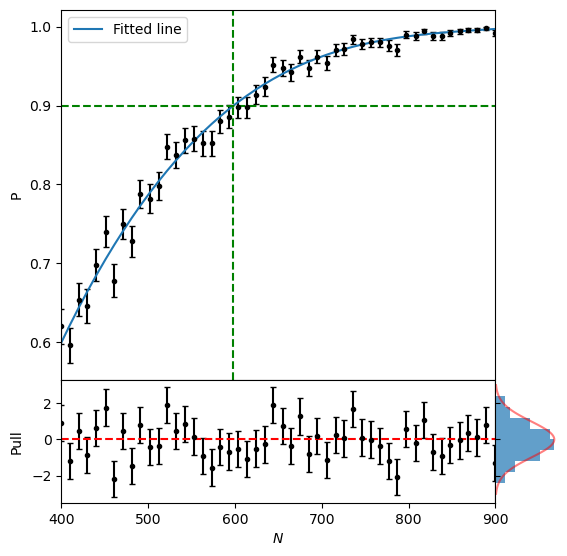

In [5]:
import pandas as pd
from find_N90 import find_N90

# Load the data from the provided file
file_path = 'PN_best.pkl'
data = pd.read_pickle(file_path)

N = data['N']
P = data['P']
P_err = data['P_err']

find_N90(N, P, P_err, plot_filepath='myplot.png')